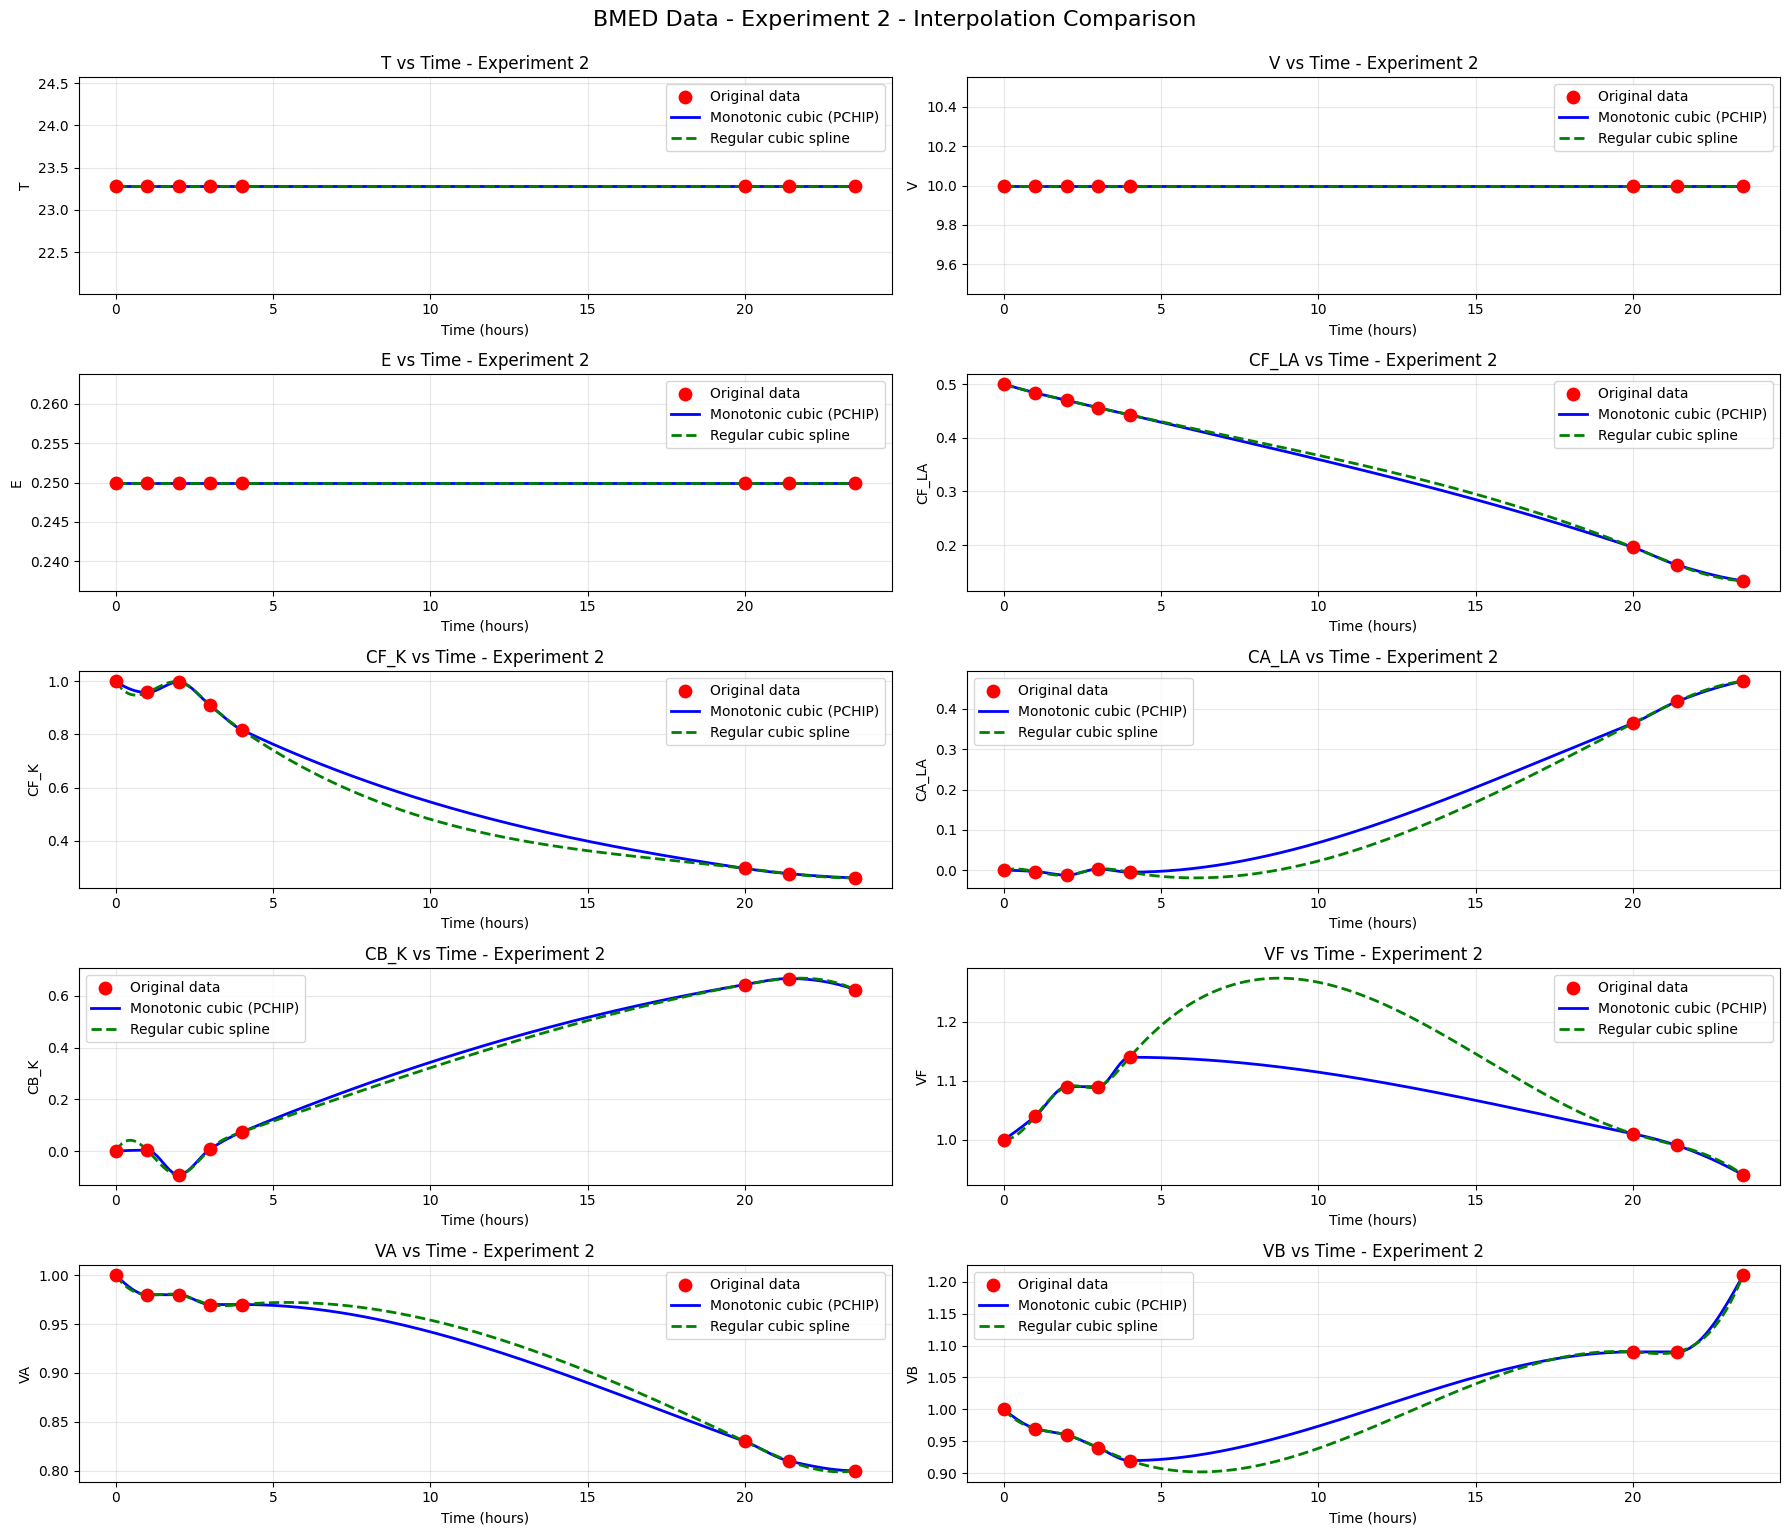


두 보간 방법의 차이 분석:
T: 최대 차이 = 0.000000, 평균 차이 = 0.000000
V: 최대 차이 = 0.000000, 평균 차이 = 0.000000
E: 최대 차이 = 0.000000, 평균 차이 = 0.000000
CF_LA: 최대 차이 = 0.010394, 평균 차이 = 0.004521
CF_K: 최대 차이 = 0.065042, 평균 차이 = 0.027394
CA_LA: 최대 차이 = 0.046555, 평균 차이 = 0.021318
CB_K: 최대 차이 = 0.039110, 평균 차이 = 0.010943
VF: 최대 차이 = 0.153493, 평균 차이 = 0.061561
VA: 최대 차이 = 0.013238, 평균 차이 = 0.006251
VB: 최대 차이 = 0.036019, 평균 차이 = 0.013040


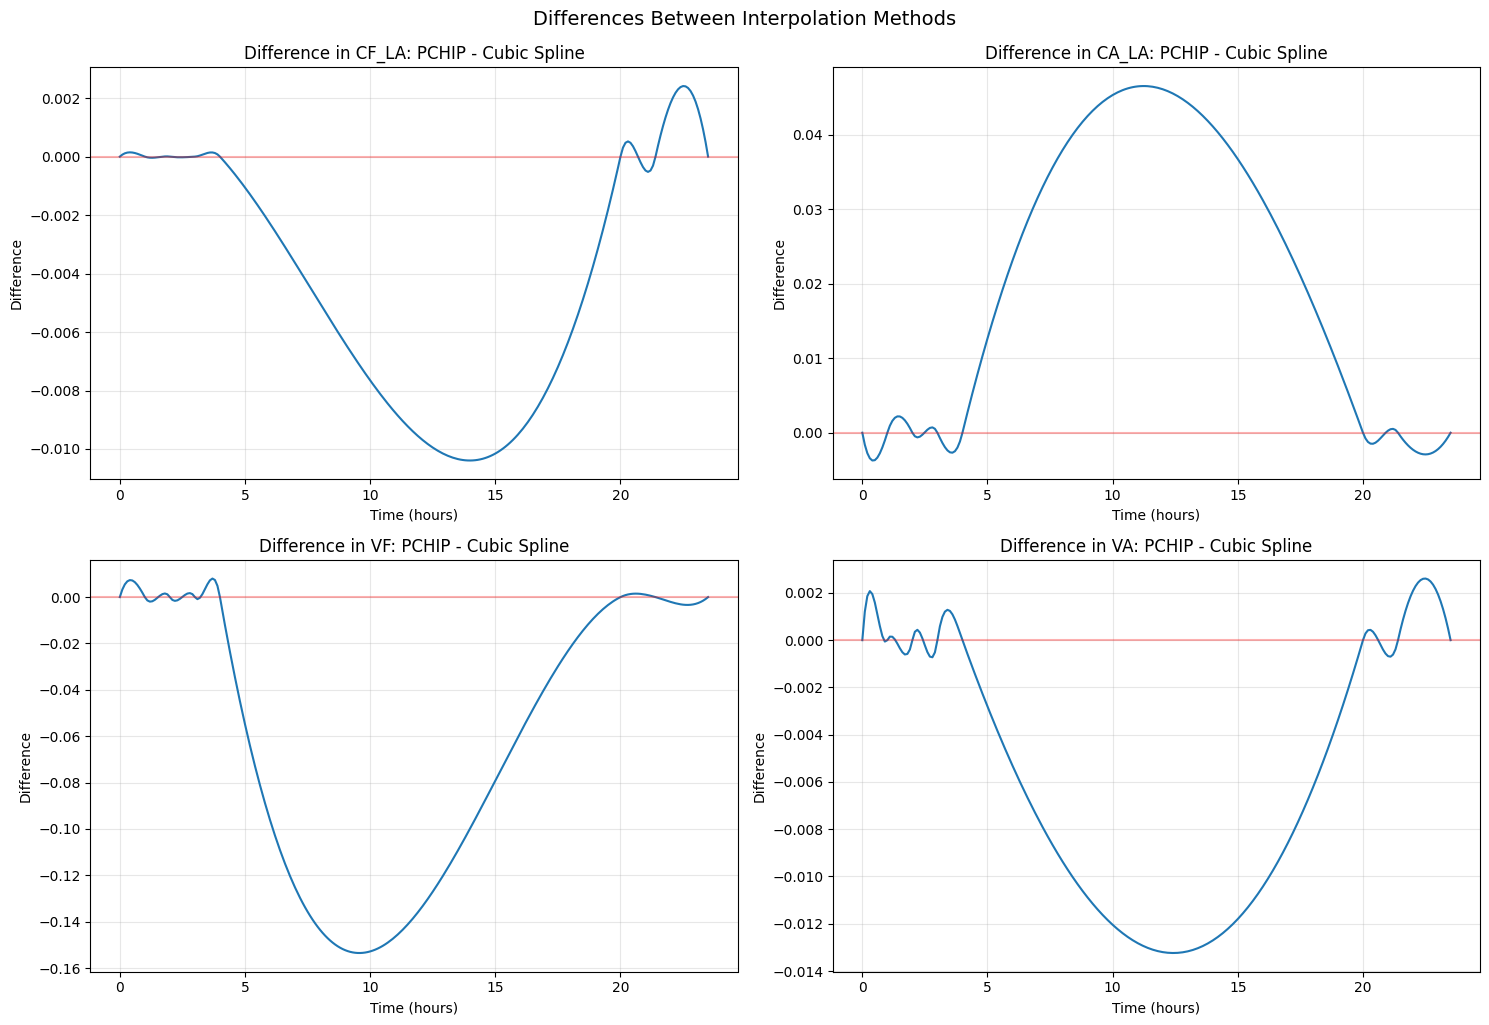

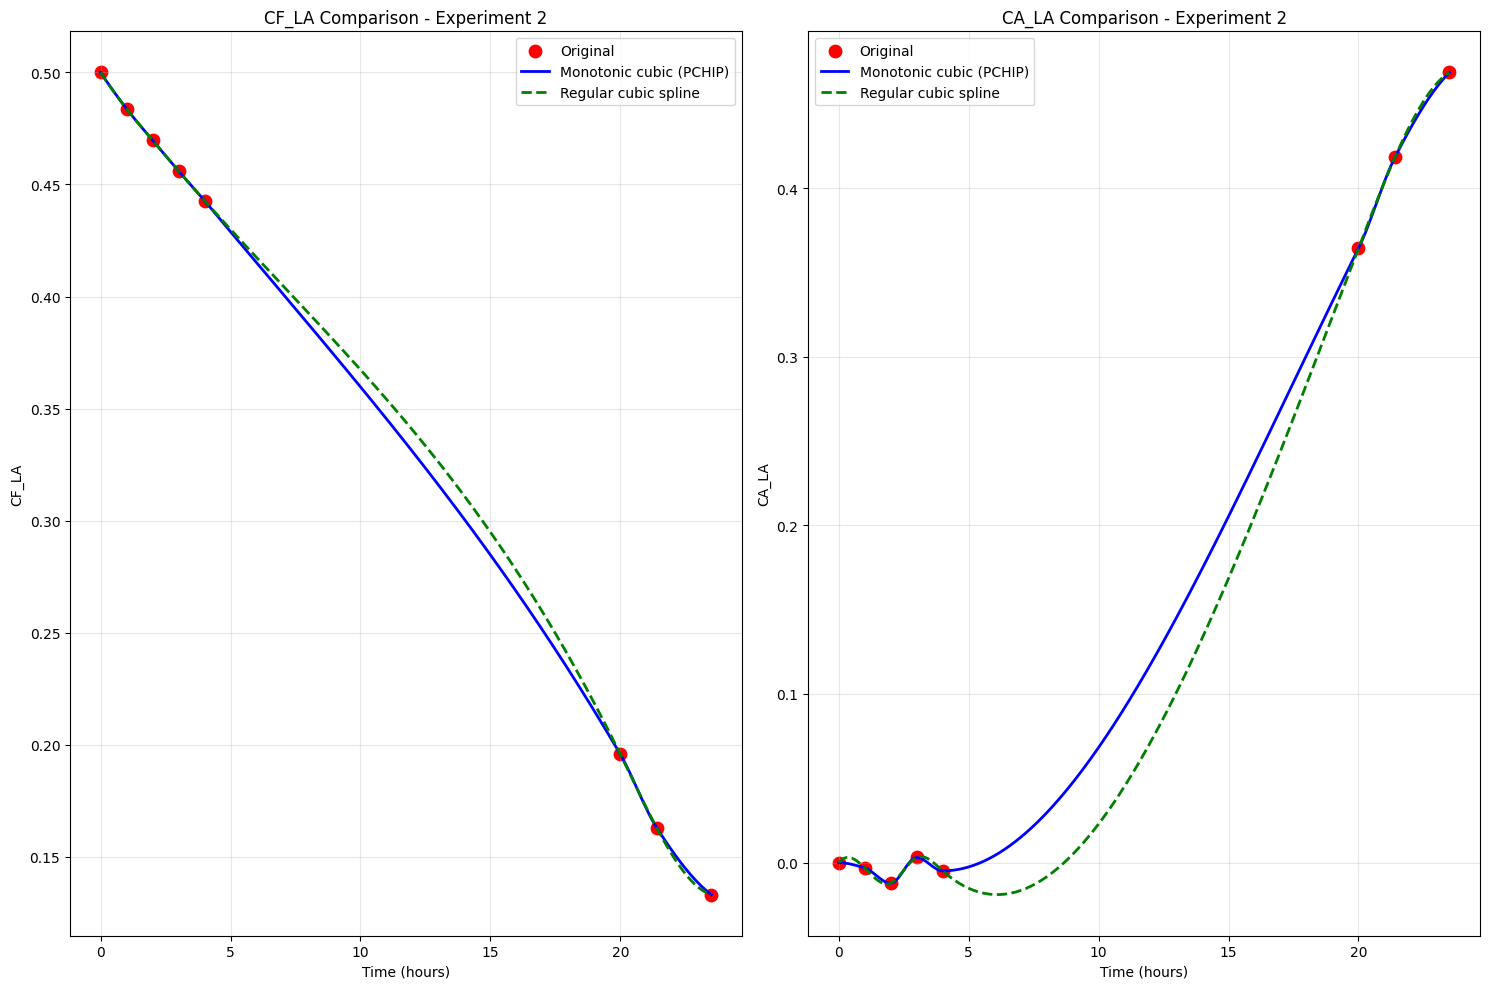


보간된 데이터 샘플 (PCHIP):
   exp    t          T     V     E     CF_LA      CF_K     CA_LA      CB_K  \
0    1  0.0  24.816667  20.0  0.25  0.500000  1.000000  0.000000  0.000000   
1    1  0.1  24.816667  20.0  0.25  0.498631  0.999920  0.000119 -0.003416   
2    1  0.2  24.816667  20.0  0.25  0.497150  0.999681  0.000460 -0.006151   
3    1  0.3  24.816667  20.0  0.25  0.495563  0.999288  0.001000 -0.008282   
4    1  0.4  24.816667  20.0  0.25  0.493877  0.998744  0.001717 -0.009883   
5    1  0.5  24.816667  20.0  0.25  0.492097  0.998052  0.002587 -0.011030   
6    1  0.6  24.816667  20.0  0.25  0.490230  0.997216  0.003587 -0.011799   
7    1  0.7  24.816667  20.0  0.25  0.488283  0.996239  0.004694 -0.012265   
8    1  0.8  24.816667  20.0  0.25  0.486260  0.995126  0.005885 -0.012505   
9    1  0.9  24.816667  20.0  0.25  0.484169  0.993880  0.007137 -0.012593   

        VF        VA       VB  
0  1.00000  1.000000  1.00000  
1  1.00299  0.998505  0.99701  
2  1.00592  0.997040  0.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, CubicSpline
from matplotlib.gridspec import GridSpec

# 데이터 파일 로드
data_path = '../data/BMED_data_v5.csv'
df = pd.read_excel(data_path) if data_path.endswith('.xlsx') else pd.read_csv(data_path)

# 변수 이름 정의
feature_columns = ['T', 'V', 'E', 'CF_LA', 'CF_K', 'CA_LA', 'CB_K', 'VF', 'VA', 'VB']

# 각 실험별로 데이터 분리
experiments = {}
for exp_id in df['exp'].unique():
    exp_data = df[df['exp'] == exp_id].sort_values('t')
    experiments[exp_id] = exp_data

# 각 실험별로 0.1시간 간격으로 데이터 보간
interpolated_experiments_pchip = {}  # monotonic cubic (PCHIP)
interpolated_experiments_cubic = {}  # 일반 cubic spline

for exp_id, exp_data in experiments.items():
    # 원본 시간 데이터
    t_original = exp_data['t'].values
    
    # 보간할 시간 간격 생성 (0.1시간 단위)
    t_min, t_max = t_original.min(), t_original.max()
    t_interp = np.arange(t_min, t_max + 0.1, 0.1)
    
    # PCHIP 결과를 저장할 데이터프레임 초기화
    interp_df_pchip = pd.DataFrame(index=range(len(t_interp)))
    interp_df_pchip['exp'] = exp_id
    interp_df_pchip['t'] = t_interp
    
    # Cubic Spline 결과를 저장할 데이터프레임 초기화
    interp_df_cubic = pd.DataFrame(index=range(len(t_interp)))
    interp_df_cubic['exp'] = exp_id
    interp_df_cubic['t'] = t_interp
    
    # 각 특성에 대해 보간 수행
    for col in feature_columns:
        # PCHIP 보간기 생성 (Monotonic Cubic Interpolation)
        pchip = PchipInterpolator(t_original, exp_data[col].values)
        
        # 일반 Cubic Spline 보간기 생성
        cubic = CubicSpline(t_original, exp_data[col].values)
        
        # 새 시간 간격에 대한 값 계산
        interp_df_pchip[col] = pchip(t_interp)
        interp_df_cubic[col] = cubic(t_interp)
    
    # 결과 저장
    interpolated_experiments_pchip[exp_id] = interp_df_pchip
    interpolated_experiments_cubic[exp_id] = interp_df_cubic

# 1번 실험 데이터를 시각화하고 두 보간 방법 비교
exp_id = 2
original_data = experiments[exp_id]
interp_data_pchip = interpolated_experiments_pchip[exp_id]
interp_data_cubic = interpolated_experiments_cubic[exp_id]

# 시각화 설정
fig = plt.figure(figsize=(18, 15))
gs = GridSpec(5, 2, figure=fig)

# 변수별 플롯 생성
for i, col in enumerate(feature_columns):
    ax = fig.add_subplot(gs[i//2, i%2])
    
    # 원본 데이터
    ax.scatter(original_data['t'], original_data[col], color='red', s=80, 
               label='Original data', zorder=3)
    
    # PCHIP(Monotonic Cubic) 보간 데이터
    ax.plot(interp_data_pchip['t'], interp_data_pchip[col], 'b-', linewidth=2, 
            label='Monotonic cubic (PCHIP)')
    
    # 일반 Cubic Spline 보간 데이터
    ax.plot(interp_data_cubic['t'], interp_data_cubic[col], 'g--', linewidth=2, 
            label='Regular cubic spline')
    
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel(col)
    ax.set_title(f'{col} vs Time - Experiment {exp_id}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.suptitle(f'BMED Data - Experiment {exp_id} - Interpolation Comparison', 
             fontsize=16, y=1.02)
plt.show()

# 두 보간 방법의 차이를 정량적으로 보여주기
print("\n두 보간 방법의 차이 분석:")
for col in feature_columns:
    # 두 보간 방법 간의 차이 계산
    diff = np.abs(interp_data_pchip[col].values - interp_data_cubic[col].values)
    max_diff = np.max(diff)
    avg_diff = np.mean(diff)
    
    print(f"{col}: 최대 차이 = {max_diff:.6f}, 평균 차이 = {avg_diff:.6f}")

# 몇 가지 변수에 대해 보간 방법 간의 차이를 시각화
plt.figure(figsize=(15, 10))
selected_cols = ['CF_LA', 'CA_LA', 'VF', 'VA']

for i, col in enumerate(selected_cols):
    plt.subplot(2, 2, i+1)
    
    # 차이 계산
    diff = interp_data_pchip[col].values - interp_data_cubic[col].values
    
    plt.plot(interp_data_pchip['t'], diff)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title(f'Difference in {col}: PCHIP - Cubic Spline')
    plt.xlabel('Time (hours)')
    plt.ylabel('Difference')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Differences Between Interpolation Methods', fontsize=14, y=1.02)
plt.show()

# 원본 데이터와 각 보간 방법 간의 비교 (특정 변수에 대해)
plt.figure(figsize=(15, 10))
selected_cols = ['CF_LA', 'CA_LA']

for i, col in enumerate(selected_cols):
    plt.subplot(1, 2, i+1)
    
    # 원본 데이터
    plt.scatter(original_data['t'], original_data[col], color='red', s=80, 
                label='Original')
    
    # PCHIP 보간
    plt.plot(interp_data_pchip['t'], interp_data_pchip[col], 'b-', linewidth=2, 
             label='Monotonic cubic (PCHIP)')
    
    # Cubic Spline 보간
    plt.plot(interp_data_cubic['t'], interp_data_cubic[col], 'g--', linewidth=2, 
             label='Regular cubic spline')
    
    plt.title(f'{col} Comparison - Experiment {exp_id}')
    plt.xlabel('Time (hours)')
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# 보간된 데이터를 하나의 DataFrame으로 결합
all_interp_data_pchip = pd.concat(interpolated_experiments_pchip.values(), ignore_index=True)
all_interp_data_cubic = pd.concat(interpolated_experiments_cubic.values(), ignore_index=True)

# 보간된 데이터의 첫 몇 행 출력
print("\n보간된 데이터 샘플 (PCHIP):")
print(all_interp_data_pchip[all_interp_data_pchip['exp'] == 1].head(10))

print("\n보간된 데이터 샘플 (Cubic Spline):")
print(all_interp_data_cubic[all_interp_data_cubic['exp'] == 1].head(10))